<h1><b>Mô hình hóa dữ liệu</b></h1>

<hr/>


<h3><b>Install & Import</b></h3>

Cài đặt và import những thư viện cần thiết cho phần mô hình hóa dữ liệu.

In [1]:
#Cài đặt các thư viện

In [ ]:
#Import các thư viện
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from datetime import timezone
import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import chi2
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

### Bài toán: 

Dự đoán số lượng ứng viên đăng kí một công việc dựa trên các đặc trưng của công việc đó (trình độ, mức lương, quy mô của công ty,...) 

#### Các thuật toán sử dụng:
- Multiple layer perception Regression 
- Random Forest Regression 

### Chuẩn bị dữ liệu

Ở bước này ta sẽ chọn ra những thuộc tính có mức độ liên quan cao, có thể khai thác cho bài toán

In [3]:
#Đọc dữ liệu
data_df = pd.read_csv('data/job_list.csv')
data_df.head()

,Unnamed: 0,jobId,jobTitle,userId,companyLogo,alias,approvedOn,expiredOn,companyName,companyId,...,numOfApplications,isMobileHotJob,isMobileTopJob,isBoldAndRedJob,isUrgentJob,isUrgentJobM,onlineOn,visibilityDisplay,priorityOrder,typeWorkingName
0,0,1581202,Project Management Manager - Attractive Salary...,5975282,https://images.vietnamworks.com/pictureofcompa...,project-management-manager-attractive-salary,2022-11-18 15:59:04+07:00,2022-12-18 23:59:59+07:00,Công Ty TNHH Công Nghệ Welco Việt Nam,313962,...,24,False,False,False,False,False,2022-11-26 11:34:00+07:00,False,2022-11-26 11:34:00,Full-time
1,1,1593683,Production Supervisor,5975282,https://images.vietnamworks.com/pictureofcompa...,production-supervisor-351,2022-11-18 09:38:08+07:00,2022-12-18 23:59:59+07:00,Công Ty TNHH Công Nghệ Welco Việt Nam,313962,...,7,False,False,False,False,False,2022-11-26 11:34:00+07:00,False,2022-11-26 11:34:00,Full-time
2,2,1594103,[Datatech Beeginner] Chuyên Viên Đảm Bảo An Ni...,417756,https://images.vietnamworks.com/pictureofcompa...,datatech-beeginner-chuyen-vien-dam-bao-an-ninh...,2022-11-18 18:08:52+07:00,2022-12-18 23:59:59+07:00,Ngân Hàng Thương Mại Cổ Phần Quân Đội - MB,2332,...,0,True,True,False,True,False,2022-11-26 11:34:00+07:00,False,2022-11-26 11:34:00,Full-time
3,3,1589116,"Trưởng Bộ Phận Tổng Hợp Báo Cáo, Phòng Kế Hoạc...",2859613,https://images.vietnamworks.com/pictureofcompa...,truong-bo-phan-tong-hop-bao-cao-phong-ke-hoach...,2022-11-04 09:59:37+07:00,2022-12-04 23:59:59+07:00,Ngân Hàng TMCP Đại Chúng Việt Nam,136607,...,10,True,True,False,False,False,2022-11-26 11:34:00+07:00,False,2022-11-26 11:34:00,Full-time
4,4,1589145,Lập Trình Viên Java C,1465669,https://images.vietnamworks.com/pictureofcompa...,lap-trinh-vien-java-c-1-1,2022-11-04 10:40:07+07:00,2022-12-04 23:59:59+07:00,Tập Đoàn MK - MK Group,60453,...,3,True,True,False,False,False,2022-11-26 11:34:00+07:00,False,2022-11-26 11:34:00,Full-time


Ở đây, ta có tất cả 38 cột, song ta sẽ bỏ qua các cột quá đặc thù khó có thể khai thác như **jobId**, **jobTitle**, **userId**, **companyLogo**,**alias**,...

Những cột chúng ta sẽ lấy là: **numOfApplications**, **salary**, **skills**, **industries**, **workingLocations**, **jobLevel**, **companySize**, **approvedOn**, **typeWorkingName**

In [4]:
#Lấy ra dữ liệu cần thiết cho dự đoán
application_df = data_df[['numOfApplications','salary','skills','industries','workingLocations','jobLevel','companySize','approvedOn','typeWorkingName']].copy()

### Tiền xử lý

#### Kiểm tra các giá trị thiếu

In [5]:
application_df.isna().sum()

numOfApplications       0
salary                  0
skills                  0
industries              0
workingLocations        0
jobLevel                0
companySize          1189
approvedOn              0
typeWorkingName         0
dtype: int64

Ở cột **companySize**, dữ liệu bị thiếu khá nhiều, việc bỏ đi không phù hợp với trường hợp này vì sẽ làm mất đi lượng thông tin lớn cũng như giảm tính chính xác của bài toán đang xét, vì vậy ta sẽ điền thêm dữ liệu cho các giá trị cột này

Trước hết, cần kiểm tra kiểu dữ liệu và các giá trị của cột `companySize`

In [6]:
application_df['companySize'].head()

0      (100, 499)
1      (100, 499)
2    (1000, 4999)
3    (1000, 4999)
4      (500, 999)
Name: companySize, dtype: object

Dữ liệu ở đây là một object, trước hết chúng ta cần chuyển các dữ liệu này về dạng số và lấy trung bình, sau đó điền các giá trị thiếu bằng giá trị trung vị (tránh trường hợp khi mất cân bằng trong tập dữ liệu) 

In [7]:
#Chuyển dữ liệu từ dạng object sang numberic
application_df['companySize'] = application_df['companySize'].apply(lambda x : math.ceil(np.mean([int(size) for size in str(x).replace('(','').replace(')','').split(',')])) if not isinstance(x, float) else np.nan)

#Bổ sung các giá trị thiếu
median_size = math.floor(application_df['companySize'].median())
application_df['companySize'] = application_df['companySize'].fillna(median_size)

Ngoài ra, có thêm một vấn đề ở cột **salary** khi ở đây có rất nhiều giá trị bằng 0, được xem như những giá trị thiếu (những giá trị mà các nhà tuyển dụng không cung cấp), cũng cần bổ sung bằng giá trị trung vị ở cột này.

In [8]:
application_df['salary'].head()

0       0
1       0
2       0
3    1500
4     700
Name: salary, dtype: int64

In [9]:
median_salary = math.floor(application_df['salary'].loc[application_df['salary'] > 0].median())
application_df['salary'] = application_df['salary'].replace(to_replace = 0, value = median_salary)

#### Chuyển đổi dữ liệu ở các cột dạng `categorical` về dạng `numeric`

Tiến hành chuyển các cột không phải dạng số về số

Ở đây có nhiều cách để chuyển đổi như sử dụng `OrdinalEncoder`, `LabelEncoder`, `OneHotEncoder`,... Trong phần này, ta sẽ dùng `OneHotEncoder`.

In [10]:
ohe = OneHotEncoder()
encoder_df = pd.DataFrame(ohe.fit_transform(application_df[['jobLevel']]).toarray())
ohe.categories_[0]

ohe1_df = pd.DataFrame(ohe.fit_transform(application_df[['jobLevel']]).toarray(),columns=ohe.categories_)
ohe2_df = pd.DataFrame(ohe.fit_transform(application_df[['typeWorkingName']]).toarray(),columns=ohe.categories_)
application_df = pd.concat([application_df,ohe1_df.iloc[:,1:],ohe2_df.iloc[:,1:]],axis=1)
application_df = application_df.drop(['jobLevel','typeWorkingName'], axis=1)

Với những cột có nhiều hơn 1 giá trị, ta sẽ sử dụng `MultiLabelBinarizer`

In [11]:
application_df[['industries','skills','workingLocations']].head()

,industries,skills,workingLocations
0,Executive management;Electrical/Electronics;Pl...,English;Project Management;Communication;OEM M...,Hai Duong
1,Executive management;Production/Process;Electr...,Tiếng Anh;Giám Sát Sản Xuất;Sản Xuất;Điện Tử;Q...,Hai Duong;Hai Duong
2,IT - Software;Banking;IT - Hardware/Networking,Java;.NET;DevOps;Cloud;Kafka,Ha Noi
3,Banking,Ngân Hàng,Ha Noi
4,IT - Software;IT - Hardware/Networking;High Te...,Lập Trình Viên / Software Developer;IT Phần Cứ...,Ha Noi


In [12]:
mlb = MultiLabelBinarizer()
mlb1_df = pd.DataFrame(mlb.fit_transform(application_df['skills'].apply(lambda x : x.split(';'))),columns=mlb.classes_)
mlb2_df = pd.DataFrame(mlb.fit_transform(application_df['industries'].apply(lambda x : x.split(';'))),columns=mlb.classes_)
mlb3_df = pd.DataFrame(mlb.fit_transform(application_df['workingLocations'].apply(lambda x : x.split(';'))),columns=mlb.classes_)

application_df = pd.concat([application_df,mlb1_df,mlb2_df,mlb3_df],axis=1)
application_df = application_df.drop(['skills','industries','workingLocations'], axis=1)



Đối với cột **approvedOn**, các giá trị đang ở dạng chuỗi, ta sẽ chuyển đổi các dữ liệu này về dạng số (hiệu timestamp) với ý nghĩa là số giờ (h) đã đăng tải   

In [13]:
newest_date = application_df['approvedOn'].max()
application_df['approvedOn'] = application_df['approvedOn'].apply(lambda x : round((datetime.datetime.fromisoformat(newest_date).timestamp() - datetime.datetime.fromisoformat(x).timestamp())/3600,0))

Dữ liệu thu được sau khi hoàn tất quá trình tiền xử lý

In [14]:
application_df.head()

,numOfApplications,salary,companySize,approvedOn,"(Experienced (non-manager),)","(Fresher/Entry level,)","(Intern/Student,)","(Manager,)","(Full-time,)","(Internship,)",...,Thai Binh,Thai Nguyen,Thanh Hoa,Thua Thien-Hue,Tien Giang,Tra Vinh,Tuyen Quang,Vinh Long,Vinh Phuc,Yen Bai
0,24,1000,300.0,191.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,7,1000,300.0,198.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0,1000,3000.0,189.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,10,1500,3000.0,533.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,3,700,750.0,533.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


Tuy nhiên, sau khi chuyển tất cả các dữ liệu có được về dạng số với 7942 cột, song liệu tất cả các cột này có thật sự hữu ích cho mô hình? Hay ta sẽ chỉ lấy ra các cột có mức độ liên quan cao đến bài toán mà ở đây là đối với cột **numOfApplications**

Để làm được điều đó, nhóm sẽ sử dụng phương pháp `Feature Selection`

#### Feature Selection

Đây là một phương pháp để chọn lọc ra các đặc trưng liên quan, có giá trị đóng góp cao trong quá trình xây dựng mô hình và dự đoán.

Tại sao phải sử dụng kĩ thuật Feature selection
- Giảm chi phí tính toán về mặt thời gian và bộ nhớ (Với bài toán chứa lượng lớn các feature (cột) trong dữ liệu sẽ gây tốn bộ nhớ và gia tăng thời gian tính toán)

- Không phù hợp với các thuật toán (hiệu quả kém đi). Ví dụ như Linear, Decision tree

- Giảm hiện tượng overfit

- Model sẽ khái quát hóa hơn đối với dữ liệu mới

##### Feature Selection for Numeric

Ở đây, ta sẽ tính correlation và chọn ra các cột thực sự có ý nghĩa (có mức độ liên quan cao đến bài toán đang xét)

In [15]:
numeric_df = application_df[['numOfApplications','salary','companySize','approvedOn']].copy()
corr = numeric_df.corr()
corr

,numOfApplications,salary,companySize,approvedOn
numOfApplications,1.000000,0.026395,0.019131,0.272530
salary,0.026395,1.000000,-0.001105,0.017109
companySize,0.019131,-0.001105,1.000000,-0.011494
approvedOn,0.272530,0.017109,-0.011494,1.000000


Dùng biểu đồ heatmap để mô tả mức độ liên quan của các cột

<AxesSubplot:>

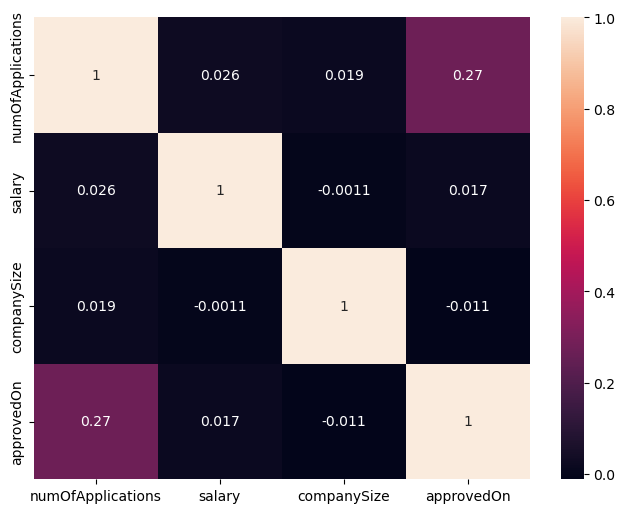

In [16]:
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True)

Vì các cột **salary**, **companySize** có corr thấp (không có ý nghĩa cho việc xây dựng mô hình), nên ta sẽ loại bỏ các cột này  

In [17]:
application_df = application_df.drop(['salary','companySize'], axis=1)

##### Feature Selection for Categorical

Ở đây nhóm sẽ sử dụng **Chi-Square** để lấy ra các đặc trưng có mức độ liên quan cao đối với các cột có kiểu là `Categorical` mà ta đã encode về dạng số trước đó

In [18]:
categorical_df = application_df.drop(['numOfApplications', 'approvedOn'], axis=1)
chi_scores = chi2(categorical_df, application_df['numOfApplications'])
chi_scores

(array([132.43441896, 231.3323097 , 471.91329554, ..., 628.4268634 ,
        148.19420978, 565.8936017 ]),
 array([9.99999994e-01, 5.73596452e-01, 6.94855886e-18, ...,
        2.07184043e-37, 9.99998414e-01, 3.96618791e-29]))

Top 10 những thuộc tính có mức độ liên quan cao nhất

<AxesSubplot:>

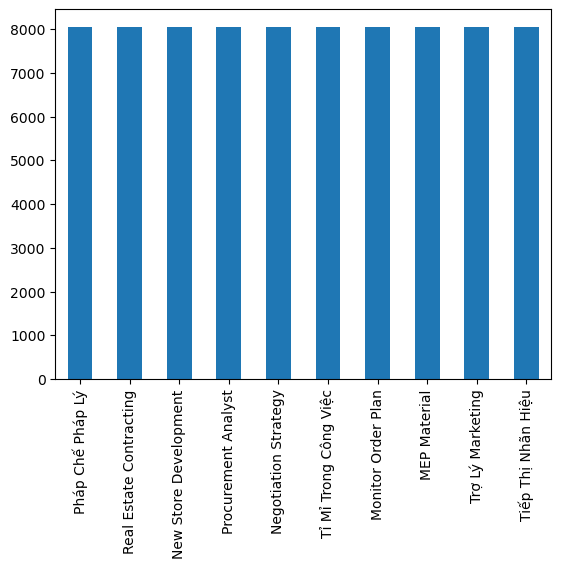

In [19]:
chi_values = pd.Series(chi_scores[0], index=categorical_df.columns)
chi_values = chi_values.sort_values(ascending=False)
chi_values[:10].plot.bar()

Top 10 những thuộc tính có mức độ liên quan thấp nhất

<AxesSubplot:>

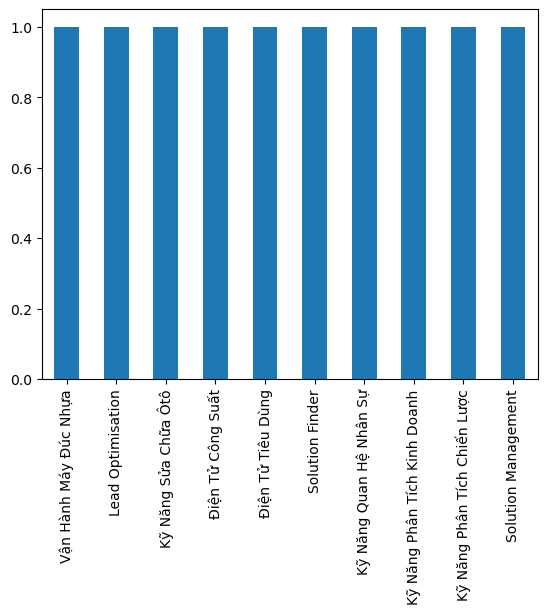

In [20]:
p_values = pd.Series(chi_scores[1], index=categorical_df.columns)
p_values = p_values.sort_values(ascending=False)
p_values[:10].plot.bar()

Ta sẽ loại bỏ đi những cột mà có p-value > 0.05 (Tức có ít liên quan đến với việc dự đoán của bài toán)

In [21]:
lower_importance_columns = p_values[p_values.values > 0.05].index.values
application_df = application_df.drop(columns=lower_importance_columns, axis=1)

Dữ liệu cuối cùng có được sử dụng cho phần dự đoán

In [22]:
application_df.head()

,numOfApplications,approvedOn,"(Intern/Student,)","(Manager,)","(Part-time,)","(Seasonal,)",2D Graphic Design,3D Modelling,ASM Miền Đông,ATM,...,Can Tho,Dong Thap,Ho Chi Minh,Khanh Hoa,Long An,Mekong Delta,Other,Tay Ninh,Vinh Long,Yen Bai
0,24,191.0,0.0,1.0,0.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,198.0,0.0,1.0,0.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,189.0,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10,533.0,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,533.0,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Multiple Layer Perception Regression


Chọn các tập dữ liệu (independent variable) X và tập giá trị (dependent variable) Y cần thiết cho việc mô hình bài toán đang xét

In [23]:
y1 = application_df['numOfApplications']
X1 = application_df.drop(['numOfApplications'],axis = 1)

Chia tập bộ dữ liệu thành các tập train (tập huấn luyện), tập test (Tập kiểm định) và tập validation (tập kiểm thử) (80:10:10)
- Tập train là tập dữ liệu được sử dụng để huấn luyện mô hình. Các thuật toán học máy sẽ học các mô hình từ tập huấn luyện này. Việc học sẽ khác nhau tùy thuộc vào thuật toán và mô hình sử dụng
- Tập test là tập giá trị được sử dụng để đánh giá độ chính xác hoặc sai số của mô hình dự đoán đã được huấn luyện. Ta cần so sánh với tập test để đánh giá khả năng tổng quát hóa với những dữ liệu không chỉ đã học mà còn với những dữ liệu mới, chưa gặp trước đó.
- Tập validation cung cấp các đánh giá công bằng về sự phù hợp của mô hình trên tập dữ liệu huấn luyện trong quá trình huấn luyện. Validation set có chức năng như một sự kết hợp: nó vừa là dữ liệu huấn luyện được sử dụng để thử nghiệm, nhưng không phải là một phần của quá trình huấn luyện cấp thấp cũng không phải là một phần của thử nghiệm cuối cùng. Nó là một bước chung gian cho phép lựa chọn mô hình phù hợp.

In [24]:
#Ta sẽ chọn 80% cho tập train và 20% cho tập test
X1_train,X1_val_test, y1_train, y1_val_test = train_test_split(X1,y1,test_size = 0.2,random_state = 0)
#Ta sẽ chọn 50% cho tập test và 50% cho tập validation (Từ tập val_test trên)
X1_val, X1_test,y1_val, y1_test = train_test_split(X1_val_test,y1_val_test,test_size = 0.5,random_state=0)

Scale dữ liệu (Feature scaling)

- Đây là một phương pháp được dùng để scale (điều chỉnh) phạm vi của các giá trị để làm cho phù hợp với các giá trị đặc trưng trong tập dữ liệu, đặc biệt đối với những tập có phạm vi chênh lệch lớn.
- Có 2 cách phổ biến để scale dữ liệu đó là Normalization và Standardization. Trong đó Normalization sẽ scale khoảng dữ liệu bất kì về 0 -> 1, còn Standardization sẽ scale dữ liệu về một phân bố trong đó giá trị trung bình của các quan sát là 0 và độ lệch chuẩn là 1.

Ở bài toán này, ta sẽ scale các dữ liệu ở các cột **salary**, **companySize**,**approvedOn** bằng phương pháp Standardization bằng StandardScaler (thư viện có sẵn của scikit-learn)

In [25]:
sc=StandardScaler()
X1_train[['approvedOn']] = sc.fit_transform(X1_train[['approvedOn']])
X1_val[['approvedOn']] = sc.fit_transform(X1_val[['approvedOn']])
X1_test[['approvedOn']] = sc.fit_transform(X1_test[['approvedOn']])

Sau khi đã chia các tập dữ liệu và scale, ta tiến hành khởi tạo mô hình Multiple layer perception Regression và đưa tập train vào để tiến hành huấn luyện.

In [26]:
mlpregressor = MLPRegressor(hidden_layer_sizes=(256, 512, 512, 256, ),random_state=0, max_iter=500, early_stopping=True, verbose=1)

model_1 = mlpregressor.fit(X1_train,y1_train)

Iteration 1, loss = 816.29149137
Validation score: 0.194178
Iteration 2, loss = 534.69306806
Validation score: 0.279616
Iteration 3, loss = 442.35160024
Validation score: 0.282275
Iteration 4, loss = 331.20079412
Validation score: 0.270303
Iteration 5, loss = 241.07307440
Validation score: 0.224717
Iteration 6, loss = 185.74938988
Validation score: 0.262003
Iteration 7, loss = 154.26889565
Validation score: 0.233974
Iteration 8, loss = 139.83485717
Validation score: 0.231855
Iteration 9, loss = 129.40809014
Validation score: 0.242811
Iteration 10, loss = 122.51755291
Validation score: 0.222708
Iteration 11, loss = 119.15164695
Validation score: 0.214522
Iteration 12, loss = 112.30615843
Validation score: 0.227717
Iteration 13, loss = 107.19694358
Validation score: 0.206388
Iteration 14, loss = 104.62457192
Validation score: 0.225908
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


Tiến hành dự đoán cho tập validation

In [27]:
y1_val_pred = model_1.predict(X1_val)

So sánh các giá trị dự đoán được với dữ liệu trong tập test

In [28]:
comparison_df = pd.DataFrame({'Actual': y1_val,'Predicted': y1_val_pred})
comparison_df

,Actual,Predicted
5878,47,33.829479
593,3,15.493029
2823,23,39.156752
5392,9,17.771997
3464,8,12.035661
...,...,...
4700,35,11.532030
7472,31,56.124741
5260,11,27.864803
2359,54,87.786244


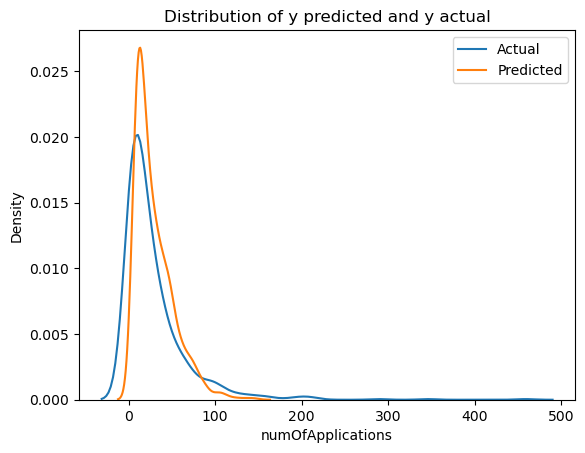

In [29]:
plt.title("Distribution of y predicted and y actual")
ax1=sns.kdeplot(y1_val, label = 'Actual')
sns.kdeplot(y1_val_pred, ax=ax1, label = 'Predicted')
ax1.legend(loc="upper right")
plt.show()

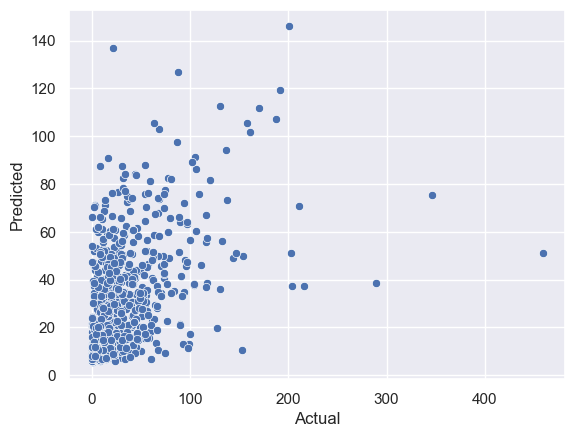

In [30]:
sns.set_theme()
sns.scatterplot(x = y1_val,y = y1_val_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

### Random Forest Regression

Chọn các tập dữ liệu (independent variable) X và tập giá trị (dependent variable) Y cần thiết cho việc mô hình bài toán đang xét

In [31]:
y2 = application_df['numOfApplications']
X2 = application_df.drop(['numOfApplications'], axis=1)

Chia tập bộ dữ liệu thành các tập train (tập huấn luyện), tập test (Tập kiểm tra) và tập validation (Tập kiểm định) (80:10:10)
- Tập train là tập dữ liệu được sử dụng để huấn luyện mô hình. Các thuật toán học máy sẽ học các mô hình từ tập huấn luyện này. Việc học sẽ khác nhau tùy thuộc vào thuật toán và mô hình sử dụng
- Tập test là tập giá trị được sử dụng để đánh giá độ chính xác hoặc sai số của mô hình dự đoán đã được huấn luyện. Ta cần so sánh với tập test để đánh giá khả năng tổng quát hóa với những dữ liệu không chỉ đã học mà còn với những dữ liệu mới, chưa gặp trước đó.
- Tập validation cung cấp các đánh giá công bằng về sự phù hợp của mô hình trên tập dữ liệu huấn luyện trong quá trình huấn luyện. Validation set có chức năng như một sự kết hợp: nó vừa là dữ liệu huấn luyện được sử dụng để thử nghiệm, nhưng không phải là một phần của quá trình huấn luyện cấp thấp cũng không phải là một phần của thử nghiệm cuối cùng. Nó là một bước chung gian cho phép lựa chọn mô hình phù hợp.

In [32]:
#Ta sẽ chọn 80% cho tập train và 20% cho tập test
X2_train,X2_val_test, y2_train, y2_val_test = train_test_split(X2,y2,test_size = 0.2,random_state = 0)
#Ta sẽ chọn 50% cho tập test và 50% cho tập validation (Từ tập val_test trên)
X2_val, X2_test,y2_val, y2_test = train_test_split(X2_val_test,y2_val_test,test_size = 0.5,random_state=0)

Scale dữ liệu (Feature scaling)

- Đây là một phương pháp được dùng để scale (điều chỉnh) phạm vi của các giá trị để làm cho phù hợp với các giá trị đặc trưng trong tập dữ liệu, đặc biệt đối với những tập có phạm vi chênh lệch lớn.
- Có 2 cách phổ biến để scale dữ liệu đó là Normalization và Standardization. Trong đó Normalization sẽ scale khoảng dữ liệu bất kì về 0 -> 1, còn Standardization sẽ scale dữ liệu về một phân bố trong đó giá trị trung bình của các quan sát là 0 và độ lệch chuẩn là 1.

Ở bài toán này, ta sẽ scale các dữ liệu ở các cột **salary**, **companySize**,**approvedOn** bằng phương pháp Standardization bằng StandardScaler (thư viện có sẵn của scikit-learn)

In [33]:
sc=StandardScaler()
X2_train[['approvedOn']] = sc.fit_transform(X2_train[['approvedOn']])
X2_test[['approvedOn']] = sc.fit_transform(X2_test[['approvedOn']])
X2_val[['approvedOn']] = sc.fit_transform(X2_val[['approvedOn']])

Sau khi đã chia các tập dữ liệu và scale, ta tiến hành khởi tạo mô hình Random Forest Regression và đưa tập train vào để tiến hành huấn luyện.

In [34]:
model_2 = RandomForestRegressor(n_estimators = 100, random_state = 0)
model_2.fit(X2_train, y2_train) 

RandomForestRegressor(random_state=0)

Tiến hành dự đoán

In [35]:
y2_val_pred = model_2.predict(X2_val)

So sánh các giá trị dự đoán được với dữ liệu trong tập test

In [36]:
comparison_df = pd.DataFrame({'Actual': y2_val,'Predicted': y2_val_pred})
comparison_df

,Actual,Predicted
5878,47,26.087167
593,3,5.504667
2823,23,46.782000
5392,9,19.840000
3464,8,4.870905
...,...,...
4700,35,10.415833
7472,31,76.780000
5260,11,10.216548
2359,54,37.626000


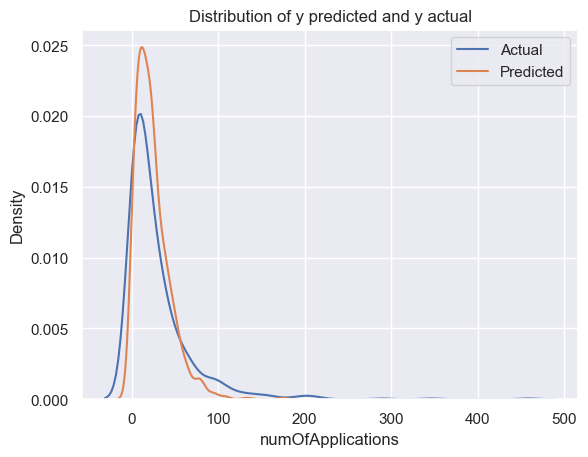

In [37]:
plt.title("Distribution of y predicted and y actual")
ax1=sns.kdeplot(y2_val, label = 'Actual')
sns.kdeplot(y2_val_pred, ax=ax1, label = 'Predicted')
ax1.legend(loc="upper right")
plt.show()

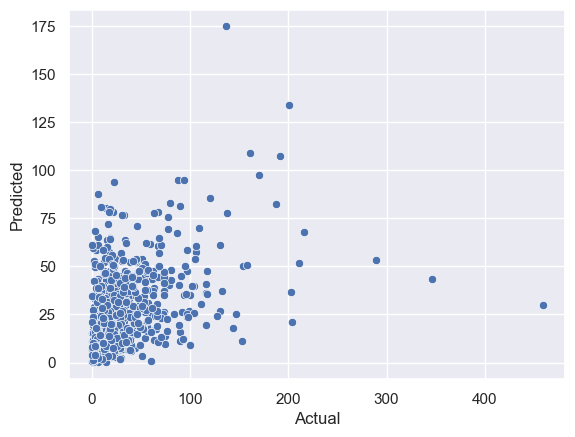

In [38]:
sns.set_theme()
sns.scatterplot(x = y2_val,y = y2_val_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

<h1><b>Đánh giá mô hình (Evaluation)</b></h1>

<hr/>

<h3><b> Kiểm thử mô hình </b></h3>

In [39]:
# Mô hình Multiple layer perception regression
y1_pred = model_1.predict(X1_test)
# Mô hình Random Forest Regression
y2_pred = model_2.predict(X2_test)

<h3><b> R² Score , the coefficient of determination</b></h3>

- $R^2 score$ thường được kí hiệu là $R^2$, dùng để đánh giá hiệu xuất của mô hình máy học dựa trên hồi quy.

- $R^2 score$ biểu thị tỷ lệ phương sai (của y) đã được giải thích bởi các biến độc lập trong mô hình. Nó cung cấp một dấu hiệu về mức độ phù hợp và do đó là thước đo xem các mẫu không nhìn thấy có khả năng được mô hình dự đoán tốt như thế nào, thông qua tỷ lệ phương sai được giải thích.

- Giá trị $R^2$ dao động từ 0 đến 1. $R^2$ càng gần 1 thì mô hình đã xây dựng càng phù hợp với bộ dữ liệu dùng chạy hồi quy. $R^2$ càng gần 0 thì mô hình đã xây dựng càng kém phù hợp với bộ dữ liệu dùng chạy hồi quy. Ngoài ra nó có thể âm (vì mô hình có thể xấu đi tùy ý).

$R^2 score$ được định nghĩa bằng công thức:

![title](https://i.postimg.cc/25VNLhmh/Screenshot-641.png)

Trong đó: 
- $yhat_i$ là là giá trị dự đoán của mẫu thứ i.
- $y_i$ là giá trị thực của mẫu thứ i
- n là tổng số mẫu

In [40]:
def R2_Score(y_test,y_pred):
    rss = np.sum(np.square(y_test - y_pred))
    tss = np.sum(np.square(y_test - np.mean(y_test)))
    return 1 - (rss/tss)

<h3><b>Đánh giá mô hình</b></h3>

### Multiple Layer Perception Regression

In [41]:
print('R Square (R^2)             : ',R2_Score(y1_test,y1_pred))
print('R Square (R^2) with sklearn: ', r2_score(y1_test,y1_pred))

R Square (R^2)             :  0.27308814722925734
R Square (R^2) with sklearn:  0.27308814722925734


### Random Forest Regression

In [42]:
print('R Square (R^2)             : ',R2_Score(y2_test,y2_pred))
print('R Square (R^2) with sklearn: ', r2_score(y2_test,y2_pred))

R Square (R^2)             :  0.16967481780481375
R Square (R^2) with sklearn:  0.16967481780481375


### Từ kết quả của $R^2 score$ ta rút ra nhận xét:
- Cả hai mô hình đều chưa thực sự tối ưu đối với bộ dữ liệu.
- Nguyên nhân phần lớn đến từ bộ dữ liệu ta thu thập có thể chưa đủ lớn.
- Có thể bị thiếu đối với những thông tin đầu vào ảnh hưởng đến dự đoán.

<h3><b> Đánh giá hồi quy Mean Absolute Error (MAE) </b></h3>

Công thức: MAE = $\large \frac{\sum_{i=1}^{n}|x_i-y_i|}{n}$

Xây dựng hàm mae():
- y_true: các giá trị trong tập test.
- y_pred: các giá trị trong tập dự đoán.
- Giá trị trả về: độ lớn trung bình của các lỗi giữa tập test và tập dự đoán.

In [43]:
def mae(y_true, y_pred):
    return sum(abs(y_true - y_pred)) / len(y_true)

<h3><b>Đánh giá mô hình</b></h3>

### Multiple Layer Perception Regression

In [44]:
print('Mean Absolute Error (MAE)             : ', mae(y1_test,y1_pred))
print('Mean Absolute Error (MAE) with sklearn: ', mean_absolute_error(y1_test,y1_pred))

Mean Absolute Error (MAE)             :  19.10189764272016
Mean Absolute Error (MAE) with sklearn:  19.101897642720164


### Random Forest Regression

In [45]:
print('Mean Absolute Error (MAE)             : ', mae(y2_test,y2_pred))
print('Mean Absolute Error (MAE) with sklearn: ', mean_absolute_error(y2_test,y2_pred))

Mean Absolute Error (MAE)             :  18.94059971318819
Mean Absolute Error (MAE) with sklearn:  18.940599713188202


### Từ kết quả của $Mean Absolute Error$ ta rút ra nhận xét:
- Độ sai lệch của dữ liệu tập test và tập dự đoán cao, nên mô hình chưa tối ưu.

Nguyên nhân: Phần lớn đến từ tập dữ liệu bị thiếu nhiều dẫn đến việc bổ sung dữ liệu ảnh hưởng kết quả dự đoán của mô hình. 